In [1]:
import numpy as np
import pandas as pd
import random 
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
import pandas as pd 
import yaml 
import matplotlib.pyplot as plt; plt.ion()
from matplotlib import rc, rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter

In [2]:
def read_config(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

config = read_config("./old_config.yaml")

In [3]:
def load_shear_data(shear_cat_path, ra_col, dec_col, g1_col, g2_col, weight_col):
    """ 
    Load shear data from a FITS file and return a pandas DataFrame.

    :param path: Path to the FITS file.
    :param ra_col: Column name for right ascension.
    :param dec_col: Column name for declination.
    :param g1_col: Column name for the first shear component.
    :param g2_col: Column name for the second shear component.
    :param weight_col: Column name for the weight.
    :return: pandas DataFrame with the specified columns.
    """
    # Read data from the FITS file
    shear_catalog = Table.read(shear_cat_path)

    # Convert to pandas DataFrame
    shear_df = pd.DataFrame({
        'ra': shear_catalog[ra_col],
        'dec': shear_catalog[dec_col],
        'g1': shear_catalog[g1_col],
        'g2': shear_catalog[g2_col],
        'weight': shear_catalog[weight_col]
    })

    return shear_df

In [4]:
def calculate_field_boundaries(ra, dec, resolution):
    """
    Calculate the boundaries of the field in right ascension (RA) and declination (Dec).
    
    :param ra: Dataframe column containing the right ascension values.
    :param dec: Dataframe column containing the declination values.
    :param resolution: Resolution of the map in arcminutes.
    :return: A dictionary containing the corners of the map {'ra_min', 'ra_max', 'dec_min', 'dec_max'}.
    """
    # Calculate median RA and Dec
    med_ra = np.median(ra)
    med_dec = np.median(dec)
    
    # Calculate the range of RA and Dec values
    ra_range = np.max(ra) - np.min(ra)
    dec_range = np.max(dec) - np.min(dec)
    
    # Calculate the size of the field in degrees
    ra_size = ra_range * np.cos(np.deg2rad(med_dec))  # Adjust for declination
    dec_size = dec_range
    
    # Calculate RA and Dec extents and store in a dictionary
    boundaries = {
        'ra_min': med_ra - ra_size / 2,
        'ra_max': med_ra + ra_size / 2,
        'dec_min': med_dec - dec_size / 2,
        'dec_max': med_dec + dec_size / 2
    }
    
    return boundaries

In [5]:
def _shuffle_ra_dec(shear_df):
    """
    Shuffle the 'ra' and 'dec' columns of the input DataFrame together.
    
    :param shear_df: Input pandas DataFrame.
    :return: A new pandas DataFrame with shuffled 'ra' and 'dec' columns.
    """
    # Make a copy to avoid modifying the original
    shuffled_df = shear_df.copy()

    # Combine RA and DEC into pairs
    #list?
    ra_dec_pairs = list(zip(shuffled_df['ra'], shuffled_df['dec']))
    
    # Shuffle the pairs
    random.shuffle(ra_dec_pairs)
    
    # Unzip the shuffled pairs back into RA and DEC
    shuffled_ra, shuffled_dec = zip(*ra_dec_pairs)
    
    shuffled_df['ra'] = shuffled_ra
    shuffled_df['dec'] = shuffled_dec

    return shuffled_df

In [6]:
def generate_multiple_shear_dfs(og_shear_df, num_shuffles):
    """
    Generate a list of multiple data frames with shuffled RA and DEC columns by calling the load and shuffle functions.
    Return: A list of shuffled pandas DataFrames.
    """
    # Load the original shear data
    #shear_df = load_shear_data(shear_cat_path, ra_col, dec_col, g1_col, g2_col, weight_col)
    
    # List to store the shuffled data frames (not sure if a list of these data frames is the best format rn)
    shuffled_dfs = []
    
    # Loop to generate multiple shuffled data frames
    for i in range(num_shuffles):
        shuffled_df = _shuffle_ra_dec(og_shear_df)
        shuffled_dfs.append(shuffled_df)
    
    return shuffled_dfs

In [7]:
def create_shear_grid(ra, dec, g1, g2, weight, boundaries, resolution):
    '''
    Bin values of shear data according to position on the sky.
    '''
    ra_min, ra_max = boundaries['ra_min'], boundaries['ra_max']
    dec_min, dec_max = boundaries['dec_min'], boundaries['dec_max']
    
    # Calculate number of pixels based on field size and resolution
    npix_ra = int(np.ceil((ra_max - ra_min) * 60 / resolution))
    npix_dec = int(np.ceil((dec_max - dec_min) * 60 / resolution))
    
    ra_bins = np.linspace(ra_min, ra_max, npix_ra + 1)
    dec_bins = np.linspace(dec_min, dec_max, npix_dec + 1)
    
    # Digitize the RA and Dec to find bin indices
    ra_idx = np.digitize(ra, ra_bins) - 1
    dec_idx = np.digitize(dec, dec_bins) - 1
    
    # Filter out indices that are outside the grid boundaries
    valid_mask = (ra_idx >= 0) & (ra_idx < npix_ra) & (dec_idx >= 0) & (dec_idx < npix_dec)
    ra_idx = ra_idx[valid_mask]
    dec_idx = dec_idx[valid_mask]
    g1 = g1[valid_mask]
    g2 = g2[valid_mask]
    weight = weight[valid_mask]
    
    # Initialize the grids
    g1_grid = np.zeros((npix_dec, npix_ra))
    g2_grid = np.zeros((npix_dec, npix_ra))
    weight_grid = np.zeros((npix_dec, npix_ra))
    
    # Accumulate weighted values using np.add.at
    np.add.at(g1_grid, (dec_idx, ra_idx), g1 * weight)
    np.add.at(g2_grid, (dec_idx, ra_idx), g2 * weight)
    np.add.at(weight_grid, (dec_idx, ra_idx), weight)
    
    # Normalize the grid by the total weight in each bin (weighted average)
    #try with commented out 
    nonzero_weight_mask = weight_grid != 0
    g1_grid[nonzero_weight_mask] /= weight_grid[nonzero_weight_mask]
    g2_grid[nonzero_weight_mask] /= weight_grid[nonzero_weight_mask]
    
    return g1_grid, g2_grid

In [8]:
def shear_grids_for_shuffled_dfs(list_of_dfs): 
    grid_list = []
    for shear_df in list_of_dfs: 
        g1map, g2map = create_shear_grid(shear_df['ra'], 
                                           shear_df['dec'], 
                                           shear_df['g1'],
                                           shear_df['g2'], 
                                           shear_df['weight'], 
                                           boundaries=boundaries,
                                           resolution=config['resolution'])

        grid_list.append((g1map, g2map))

    return grid_list

In [9]:
def ks_inversion(g1_grid, g2_grid):
    """
    Perform the Kaiser-Squires inversion to obtain both E-mode and B-mode convergence maps from shear components.
    """
    # Get the dimensions of the input grids
    npix_dec, npix_ra = g1_grid.shape

    # Fourier transform the shear components
    g1_hat = np.fft.fft2(g1_grid)
    g2_hat = np.fft.fft2(g2_grid)

    # Create a grid of wave numbers
    k1, k2 = np.meshgrid(np.fft.fftfreq(npix_ra), np.fft.fftfreq(npix_dec))
    k_squared = k1**2 + k2**2

    # Avoid division by zero by replacing zero values with a small number
    k_squared = np.where(k_squared == 0, np.finfo(float).eps, k_squared)

    # Kaiser-Squires inversion in Fourier space
    kappa_e_hat = (1 / k_squared) * ((k1**2 - k2**2) * g1_hat + 2 * k1 * k2 * g2_hat)
    kappa_b_hat = (1 / k_squared) * ((k1**2 - k2**2) * g2_hat - 2 * k1 * k2 * g1_hat)

    # Inverse Fourier transform to get the convergence maps
    kappa_e_grid = np.real(np.fft.ifft2(kappa_e_hat))
    kappa_b_grid = np.real(np.fft.ifft2(kappa_b_hat))

    return kappa_e_grid, kappa_b_grid

In [10]:
def ks_inversion_list(grid_list):
    """
    Iterate through a list of (g1map, g2map) pairs and return a list of kappa_e values.
    
    Parameters:
    shear_maps : list of tuples
        A list where each element is a tuple of (g1map, g2map)
        
    Returns:
    kappa_e_list : list
        A list containing the kappa_e maps for each (g1map, g2map) pair.
    """
    kappa_e_list = []
    kappa_b_list = []
    
    for g1map, g2map in grid_list:
        # Call the ks_inversion function for each pair
        kappa_e, kappa_b = ks_inversion(g1map, -g2map)  # We only care about kappa_e
        kappa_e_list.append(kappa_e)
        kappa_b_list.append(kappa_b)
    
    return kappa_e_list, kappa_b_list

In [11]:
def plot_convergence(convergence, boundaries, config):
    """
    Make plot of convergence map and save to file using information passed
    in run configuration file. 

    Arguments
        convergence: XXX raw convergence map XXX
        boundaries: XXX RA/Dec axis limits for plot, set in XXX
        config: overall run configuration file

    """

    # Embiggen font sizes, tick marks, etc.
    fontsize = 15
    plt.rcParams.update({'axes.linewidth': 1.3})
    plt.rcParams.update({'xtick.labelsize': fontsize})
    plt.rcParams.update({'ytick.labelsize': fontsize})
    plt.rcParams.update({'xtick.major.size': 8})
    plt.rcParams.update({'xtick.major.width': 1.3})
    plt.rcParams.update({'xtick.minor.visible': True})
    plt.rcParams.update({'xtick.minor.width': 1.})
    plt.rcParams.update({'xtick.minor.size': 6})
    plt.rcParams.update({'xtick.direction': 'in'})
    plt.rcParams.update({'ytick.major.width': 1.3})
    plt.rcParams.update({'ytick.major.size': 8})
    plt.rcParams.update({'ytick.minor.visible': True})
    plt.rcParams.update({'ytick.minor.width': 1.})
    plt.rcParams.update({'ytick.minor.size':6})
    plt.rcParams.update({'ytick.direction':'in'})
    plt.rcParams.update({'axes.labelsize': fontsize})
    plt.rcParams.update({'axes.titlesize': fontsize})

    
    # Apply Gaussian filter -- is this the right place to do it?
    # We are planning on implementing other filters at some point, right?
    filtered_convergence = gaussian_filter(convergence, config['gaussian_kernel'])

    # Make the plot!
    fig, ax = plt.subplots(
        nrows=1, ncols=1, figsize=config['figsize'], tight_layout=True
    )
    
    im = ax.imshow(
        filtered_convergence[:, ::-1], 
        cmap=config['cmap'],
        vmax=config['vmax'], 
        vmin=config['vmin'],
        extent=[boundaries['ra_max'], 
                    boundaries['ra_min'], 
                    boundaries['dec_min'], 
                    boundaries['dec_max']],
        origin='lower' # Sets the origin to bottom left to match the RA/DEC convention
    )  

    ax.set_xlabel(config['xlabel'])
    ax.set_ylabel(config['ylabel'])
    ax.set_title(config['plot_title'])

    # Is there a better way to force something to be a boolean?
    if config['gridlines'] == True:
        ax.grid(color='black')

    # Add colorbar; turn off minor axes first
    plt.rcParams.update({'ytick.minor.visible': False})
    plt.rcParams.update({'xtick.minor.visible': False})

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.07)
    fig.colorbar(im, cax=cax)

    # Save to file and exit, redoing tight_layout b/c sometimes figure gets cut off 
    fig.tight_layout() 
    plt.show()
    fig.savefig(config['output_path'])
    plt.close(fig)

In [12]:
shear_df = load_shear_data(config['input_path'], 
                                          config['ra_col'], 
                                          config['dec_col'], 
                                          config['g1_col'], 
                                          config['g2_col'], 
                                          config['weight_col'])
print(shear_df)

              ra        dec        g1        g2    weight
0     104.655406 -56.087883 -0.457485 -0.180171  4.992211
1     104.832843 -56.089083  0.615724 -0.462868  0.185507
2     104.783309 -56.089084 -0.810462 -0.568627  3.730110
3     104.770202 -56.089269 -1.880139 -0.534132  0.389534
4     104.799904 -56.089313 -0.849809 -0.129802  4.599156
...          ...        ...       ...       ...       ...
3604  104.581113 -55.930026  1.060091 -0.287627  4.570508
3605  104.731479 -55.930364  0.312710  0.425442  4.731398
3606  104.303661 -55.928424 -0.692010 -0.381118  4.801212
3607  104.937961 -55.930362 -0.678165 -0.330260  4.985500
3608  104.467693 -55.930481 -0.098573  0.260276  4.724180

[3609 rows x 5 columns]


In [14]:
shuffled_dfs = generate_multiple_shear_dfs(shear_df, 100)
first_df = shuffled_dfs[0]
boundaries = calculate_field_boundaries(shear_df['ra'], shear_df['dec'], config['resolution'])
#for shear_df in shuffled_dfs:
    #print(shear_df.head())

In [15]:
g1_g2_map_list = shear_grids_for_shuffled_dfs(shuffled_dfs) 

In [16]:
shuff_kappa_e_list, shuff_kappa_b_list = ks_inversion_list(g1_g2_map_list)
print(shuff_kappa_e_list[2])
print(shuff_kappa_b_list[2])

[[-0.0645115  -0.05558025 -0.12189609 ... -0.6607185   0.4187947
  -0.17838013]
 [-0.05012142 -0.13571913  0.02071723 ... -0.04978043 -0.53100576
  -0.24475045]
 [-0.03055068  0.04049132 -0.03852088 ...  0.30059611  0.50212384
   0.31747249]
 ...
 [-0.20671069 -0.84071389 -0.08069383 ...  0.16090834 -0.01409482
   0.23589629]
 [ 1.08086687  0.25335088  0.43999479 ... -0.08664629  0.31645289
   0.16596123]
 [ 0.13939411 -0.62257602  0.06706646 ... -0.12068804  0.45156845
   0.40540904]]
[[ 0.06343058  0.0830283   0.13643379 ... -0.04727299  0.03121365
  -0.3583307 ]
 [-0.02547228  0.12079708 -0.15035542 ... -0.94614439  0.17802035
   0.7652106 ]
 [ 0.11563001  0.13138297  0.1230959  ...  0.04904967  0.63962584
   0.18782108]
 ...
 [-0.74545344 -0.14643686  0.58359793 ...  0.12870349 -0.15081592
   0.20675964]
 [-0.1116314   0.48669915  0.1337864  ...  0.0454117   0.0845085
  -0.20696143]
 [ 0.72760405 -0.05009393 -0.48420016 ...  0.31673616  0.48329806
  -0.24617456]]


In [17]:
#stacks all the maps into a 3D array (axis = 0 is the depth across all the maps)
kappa_e_stack = np.stack(shuff_kappa_e_list, axis = 0)
kappa_b_stack = np.stack(shuff_kappa_b_list, axis = 0)
#takes the variance across each map for each pixel 
variance_map_e = np.var(kappa_e_stack, axis = 0)
variance_map_b = np.var(kappa_b_stack, axis = 0)

In [18]:
# Finally, computing the oringinal kappa map
g1map_og, g2map_og = create_shear_grid(shear_df['ra'], 
                                       shear_df['dec'], 
                                       shear_df['g1'],
                                       shear_df['g2'], 
                                       shear_df['weight'], 
                                       boundaries=boundaries,
                                       resolution=config['resolution'])
og_kappa_e, og_kappa_b = ks_inversion(g1map_og, -g2map_og)
std = np.sqrt(variance_map_e)
print(std)
print(og_kappa_e)

[[0.11020381 0.10405605 0.09135113 ... 0.37590278 0.36446552 0.28714665]
 [0.18743557 0.10629932 0.0834459  ... 0.44824117 0.38890591 0.38474052]
 [0.27424986 0.11438053 0.0916706  ... 0.35391734 0.53958347 0.34222952]
 ...
 [0.38485759 0.3619844  0.2829214  ... 0.11763837 0.12538003 0.2565968 ]
 [0.37302743 0.2935762  0.28316594 ... 0.09785059 0.12586361 0.17207201]
 [0.16728622 0.27442614 0.15112673 ... 0.30037918 0.28901886 0.16703518]]
[[-0.04316345  0.00758959  0.03521361 ... -0.03106111 -0.09369835
  -0.13768636]
 [ 0.15041353  0.02534575  0.03871165 ...  0.02514067  0.16100202
   0.48434929]
 [ 0.16350717  0.05684505  0.1101641  ...  0.64712159  0.09803157
  -0.10543657]
 ...
 [ 0.76665348  0.00293165  0.56961295 ...  0.26305925  0.28157283
   0.4803939 ]
 [-0.1053088  -0.31798021  0.29081982 ...  0.21987103  0.26462284
   0.21493334]
 [ 0.06752752 -0.30552014 -0.020172   ...  0.47597041  0.20711483
  -0.1336508 ]]


-1.9580652991625335e-19


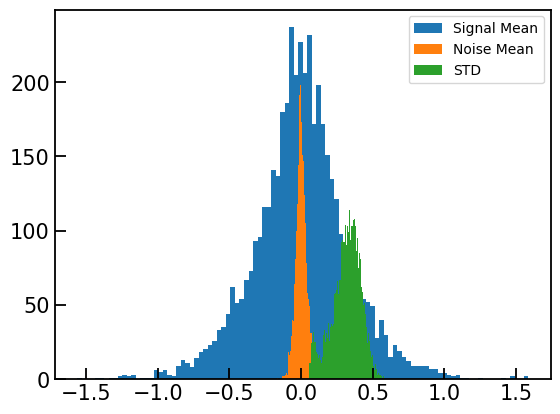

In [22]:
mean = np.mean(kappa_e_stack, axis = 0)

plt.hist(og_kappa_e.ravel(), bins = 100, label = "Signal Mean")


plt.hist(mean.ravel(), bins=100, label = "Noise Mean")
print(np.mean(mean.ravel()))

std = np.sqrt(variance_map_e)
plt.hist(std.ravel(), bins=100, label = "STD")

plt.legend()

In [20]:
median_signal = np.median(og_kappa_e)
signal_to_noise = og_kappa_e / std
print(signal_to_noise)

[[-0.3916693   0.0729375   0.38547543 ... -0.08263071 -0.25708427
  -0.47949839]
 [ 0.80248123  0.23843761  0.46391322 ...  0.05608738  0.41398708
   1.25889854]
 [ 0.59619781  0.49698184  1.20173859 ...  1.82845405  0.18168009
  -0.30808731]
 ...
 [ 1.99204459  0.00809884  2.01332579 ...  2.23616874  2.24575502
   1.87217413]
 [-0.28230845 -1.08312666  1.02702965 ...  2.24700768  2.10245706
   1.2490895 ]
 [ 0.40366457 -1.11330553 -0.13347741 ...  1.58456522  0.71661354
  -0.80013562]]


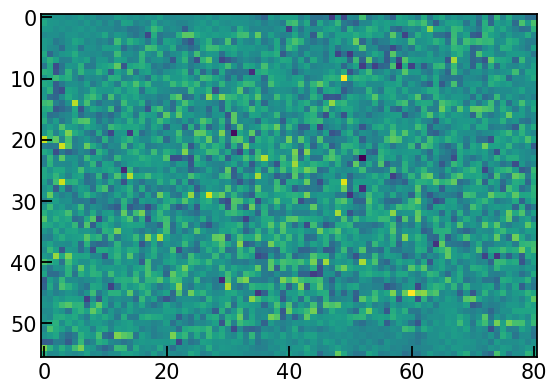

In [25]:
plt.imshow(mean, cmap = 'viridis')

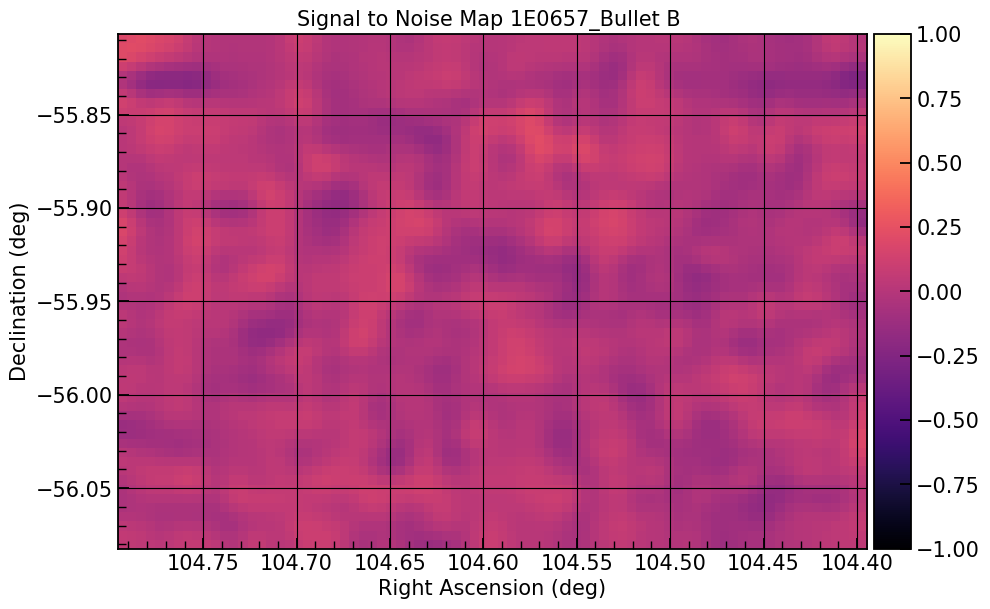

In [26]:
plot_convergence(og_kappa_e, boundaries, config)